In [3]:
import xarray as xr
import numpy as np
from jax import config
config.update("jax_enable_x64", True)
from tqdm import tqdm
from jax import numpy as jnp
from diffrax import diffeqsolve, ODETerm, SemiImplicitEuler, SaveAt
from interpax import Interpolator2D
import equinox as eqx
import jax
import optax

In [4]:
flds = xr.open_dataset("data/all-fields.nc")

In [5]:
flds

<xarray.Dataset>
Dimensions:    (t: 4000, x: 32)
Coordinates:
  * t          (t) float64 0.0 0.5 1.0 1.5 ... 1.998e+03 1.999e+03 2e+03
  * x          (x) float64 0.2641 0.7924 1.321 1.849 ... 15.05 15.58 16.11 16.64
Data variables:
    force-(x)  (t, x) float64 ...

In [6]:
xax = flds.coords["x"].data
tax = flds.coords["t"].data

dx = xax[1]-xax[0]
xmax = xax[-1] + dx/2.
dt = tax[1]-tax[0]

nv_part = 128
nx_part = xax.size

# initialize particles
xi = np.repeat(xax, nv_part)
vi = np.tile(np.linspace(-6, 6, nv_part), nx_part)

In [7]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'v ($v_{th}$)')

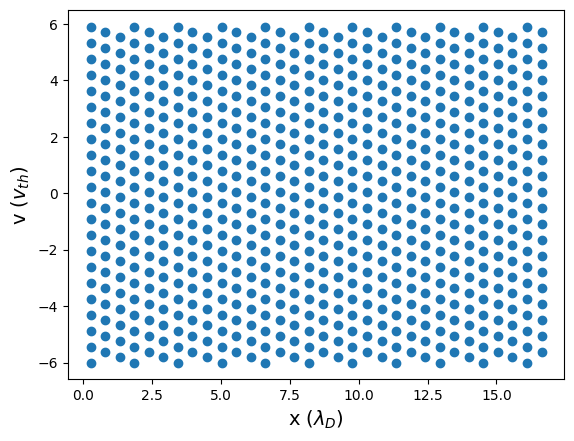

In [8]:
plt.scatter(xi[::6], vi[::6])
plt.xlabel("x ($\lambda_D$)", fontsize=14)
plt.ylabel("v ($v_{th}$)", fontsize=14)

In [9]:
nt = 2000
xp = np.zeros((nt, xi.size))
vp = np.zeros((nt, vi.size))

In [10]:
from equinox.internal import ω
import diffrax


class Leapfrog(SemiImplicitEuler):
    """Semi-implicit Euler's method.

    Symplectic method. Does not support adaptive step sizing. Uses 1st order local
    linear interpolation for dense/ts output.
    """

    def step(
        self,
        terms,
        t0,
        t1,
        y0,
        args,
        solver_state,
        made_jump,
    ):
        del solver_state, made_jump

        term_1, term_2 = terms
        y0_1, y0_2 = y0

        control1 = term_1.contr(t0, t1)
        control2 = term_2.contr(t0, t1)
        y1_1 = (y0_1**ω + term_1.vf_prod(t0, y0, args, control1)[0] ** ω).ω
        y1_1 = jnp.where(y1_1 > xmax, y1_1 - xmax, jnp.where(y1_1 < 0, y1_1 + xmax, y1_1))
        
        y1_2 = (y0_2**ω + term_2.vf_prod(t0, (y1_1, y0_2), args, control2)[0] ** ω).ω

        y1 = (y1_1, y1_2)
        dense_info = dict(y0=y0, y1=y1)
        return y1, None, dense_info, None, diffrax.RESULTS.successful


def dxdt(t, y, args):
    return y[1], y[1]

efield = Interpolator2D(tax, xax, flds["force-(x)"].data, method="linear", period=(None, xmax))

def dvdt(t, y, args):
    # it = (t/0.5).astype(jnp.int32)
    # print(it)
    # return jnp.interp(y[0], xax, args["e"][it], period=xmax)
    print(jnp.full_like(y[0], t).shape)
    print(y[0].shape)
    return efield(jnp.full_like(y[0], t), y[0]), y[1]

In [128]:
xi = jnp.array([0.0, 0.0])
vi = jnp.array([-1.0, 1.0])

tmax = 2000
dt = 0.5
ground_truth = diffeqsolve((ODETerm(dxdt), ODETerm(dvdt)), solver=Leapfrog(), t0=0., t1=tmax, dt0=dt, y0=(xi, vi), 
                     args={"e": flds["force-(x)"].data}, 
                     saveat=SaveAt(ts=np.linspace(1, tmax-10, int(tmax//dt//2))))

(2,)
(2,)
(2,)
(2,)


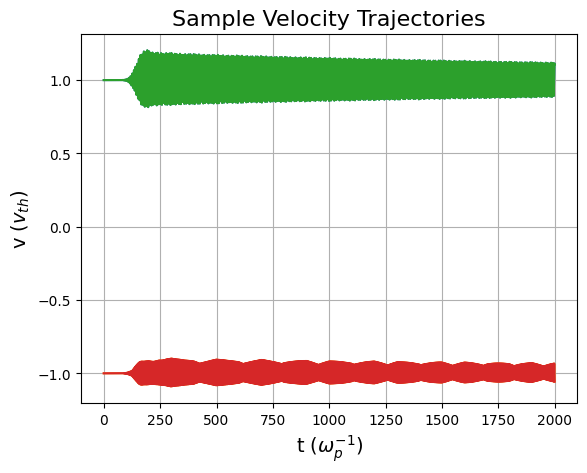

In [92]:
def sample_trajectories(n_traj):
    ipart = np.random.choice(np.arange(xi.size), n_traj, replace=False)
    for ip in ipart:
        # plt.plot(vp[:, ip])
        plt.plot(ground_truth.ys[1][:, ipart])
    plt.grid()
    plt.ylabel("v ($v_{th}$)", fontsize=14)
    plt.xlabel("t ($\omega_p^{-1}$)", fontsize=14)
    plt.title("Sample Velocity Trajectories", fontsize=16)
sample_trajectories(2)


In [169]:
class Hamiltonian(eqx.Module):
    ham_model: eqx.Module
    _dxdt_: eqx.Module
    _dvdt_: eqx.Module
    
    def __init__(self, model):
        self.ham_model = model
        self._dxdt_ = eqx.filter_vmap(jax.grad(self.ham_func, argnums=2))
        self._dvdt_ = eqx.filter_vmap(jax.grad(self.ham_func, argnums=1))
        
    def dxdt(self, t, y, args):
        __dxdt__ = self._dxdt_(jnp.full_like(xi, t), y[0], y[1])
        return __dxdt__, y[1]

    def dvdt(self, t, y, args):
        __dvdt__ = -self._dvdt_(jnp.full_like(xi, t), y[0], y[1])
        return __dvdt__, y[1]

    def ham_func(self, t, x, v):
        return jnp.squeeze(self.ham_model(jnp.array([t, x, v])))

ham_model = eqx.nn.MLP(3, 1, 8, 4, activation=jax.nn.tanh, key = jax.random.PRNGKey(42))

th = Hamiltonian(ham_model)

In [170]:
th.ham_func(20., xi[0], vi[0])

Array(-0.05451869, dtype=float64)

In [171]:
def integrate_ham(this_model):
    th = Hamiltonian(this_model)
    result = diffeqsolve((ODETerm(th.dxdt), ODETerm(th.dvdt)), solver=Leapfrog(), t0=0., t1=tmax, dt0=dt, y0=(xi, vi), 
                     saveat=SaveAt(ts=np.linspace(1, tmax-10, int(tmax//dt//2))))

    return result

def loss(this_ham):
    result = integrate_ham(this_ham)
    return jnp.mean(jnp.square(result.ys[0] - ground_truth.ys[0]))

In [172]:
result = integrate_ham(ham_model)

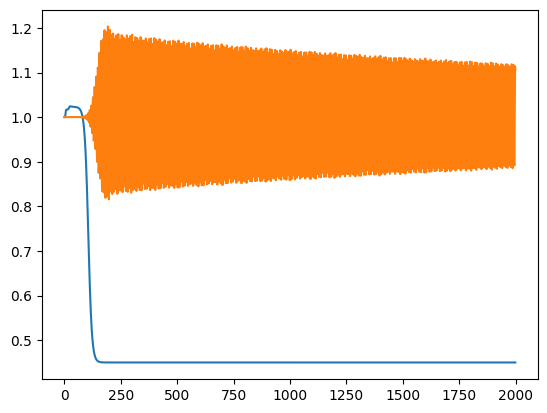

In [173]:
result = integrate_ham(ham_model)
plt.plot(result.ys[1][:, 104])
plt.plot(ground_truth.ys[1][:, 104])

In [102]:
params = ham_model
optim = optax.adam(1e-3)
opt_state = optim.init(eqx.filter(params, eqx.is_array))

for i in range(10):
    loss_value, grads = eqx.filter_jit(eqx.filter_value_and_grad(loss))(params)
    updates, opt_state = optim.update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    

# Trying out the training process from the HNN paper

Here we're going to try directly optimizing the loss
$ \| dH/dp - dq/dt \|_2 + \| dH/dq + dp/dt \|_2. $

We're going to "cheat" by using our knowledge of what dq/dt and dp/dt are in terms of the time-dependent field.

In [205]:
hnn_model_1 = eqx.nn.MLP(3, 1, 8, 4, activation=jax.nn.tanh, key = jax.random.PRNGKey(42))


class HNN:
    def __init__(self, ham):
        self.ham = ham
    
    # A function we can take the jax derivative of
    def ham_func(self, x, v, t):
        return jnp.squeeze(self.ham(jnp.array([x, v, t])))
    

def loss_1(ham):
    H = HNN(ham)
    
    xs = ground_truth.ys[0][400:500, :]
    vs = jnp.ravel(ground_truth.ys[1][400:500, :])
    ts = jnp.ravel(jnp.full_like(xs, jnp.reshape(ground_truth.ts, (xs.shape[0], 1))))
    xs = jnp.ravel(xs)
    
    dH_dv = jax.vmap(jax.grad(H.ham_func, argnums=2))
    dH_dx = jax.vmap(jax.grad(H.ham_func, argnums=1))
    dx_dt = jnp.ravel(vs)
    dv_dt = efield(xs, ts)

    L_vx = jnp.mean(jnp.square(dH_dv(xs, vs, ts) - dx_dt))
    L_xv = jnp.mean(jnp.square(dH_dx(xs, vs, ts) + dv_dt))

    L = L_vx + L_xv

    return L
    

params = hnn_model_1
optim = optax.adam(1e-2)
opt_state = optim.init(eqx.filter(params, eqx.is_array))

for i in range(1000):
    loss_value, grads = eqx.filter_jit(eqx.filter_value_and_grad(loss))(params)
    if i % 50 == 0:
        print(i, loss_value)
    updates, opt_state = optim.update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    

0 86.53755472469012
50 22.777630004888035
100 22.604431939285984
150 22.48135204285777
200 22.411872853539005
250 22.34726344491115
300 22.32108947353218


KeyboardInterrupt: 

In [66]:
def efield_loss(model, tstart, tend):
    ts = tax[tstart:tend]
    that = (ts - jnp.mean(ts)) / jnp.std(ts)
    f = jax.vmap(lambda t: model(jnp.array([t])))
    return jnp.mean(jnp.square(efield(ts, 3.4) - f(that)))

In [81]:
efield_model_1 = eqx.nn.MLP(1, 1, 20, 4, activation=jax.nn.relu, key = jax.random.PRNGKey(42))
params = efield_model_1
optim = optax.adam(1e-3)
opt_state = optim.init(eqx.filter(params, eqx.is_array))

for epoch in range(100):
    print("epoch", epoch)
    for batch in range(10):
        tstart = 1000 + batch * 4
        tend = 1000 + (batch + 1) * 4
        loss = lambda model: efield_loss(model, tstart, tend)
        loss_value, grads = eqx.filter_jit(eqx.filter_value_and_grad(loss))(params)
        if epoch % 5 == 0 and batch % 10 == 0:
            print(epoch, batch, loss_value)
        updates, opt_state = optim.update(grads, opt_state)
        params = eqx.apply_updates(params, updates)


ts = tax[tstart:tend]
that = (ts - jnp.mean(ts)) / jnp.std(ts)
print(that)

epoch 0
0 0 0.049236972003037935
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
5 0 0.010050208153711758
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
10 0 0.00914119386067733
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
15 0 0.00921379282060981
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
20 0 0.00919135556699536


KeyboardInterrupt: 

0.002650667690633508


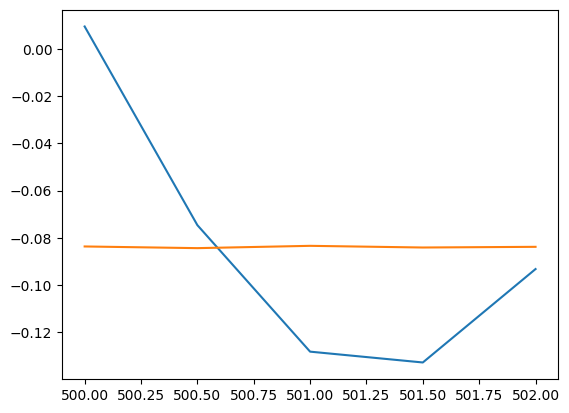

In [78]:
expected = efield(ts, 3.4)
plt.plot(ts, efield(ts, 3.4))
f = jax.vmap(lambda t: params(jnp.array([t])))
actual = f(that)
print(jnp.mean(jnp.square(expected - actual)))
plt.plot(ts, f(that))

In [56]:
params

MLP(
  layers=(
    Linear(
      weight=f64[20,1],
      bias=f64[20],
      in_features=1,
      out_features=20,
      use_bias=True
    ),
    Linear(
      weight=f64[20,20],
      bias=f64[20],
      in_features=20,
      out_features=20,
      use_bias=True
    ),
    Linear(
      weight=f64[20,20],
      bias=f64[20],
      in_features=20,
      out_features=20,
      use_bias=True
    ),
    Linear(
      weight=f64[20,20],
      bias=f64[20],
      in_features=20,
      out_features=20,
      use_bias=True
    ),
    Linear(
      weight=f64[1,20],
      bias=f64[1],
      in_features=20,
      out_features=1,
      use_bias=True
    )
  ),
  activation=<wrapped function <lambda>>,
  final_activation=<function <lambda>>,
  use_bias=True,
  use_final_bias=True,
  in_size=1,
  out_size=1,
  width_size=20,
  depth=4
)

In [ ]:
import jax.numpy as jnp
import jax.random as random

# Generate random input data
key = random.PRNGKey(0)
x_train = random.uniform(key, (1000, 1), minval=-5, maxval=5)
y_train = jnp.sin(x_train)
